In [1]:
import pandas as pd
import pyarrow.dataset as pqds
from pyarrow import fs
import pyarrow as pa
import math
import os

In [2]:
os.getcwd()

'/Users/dexter/sandbox/algo_trading/crypto_feature_preprocess/notebooks'

In [3]:
data_path = "../../crypto_market_data/data/kraken.ETHUSD"
data_set_index = "dsindex"
begin_partition:int = 202001
end_partition:int = 202307
# Read parquet file from data_path as pyarrown dateset
dataset: pqds.dataset = pqds.dataset(
            data_path,
            format="parquet",
            partitioning="hive",
            filesystem=fs.LocalFileSystem(),
        )

criteria = (pqds.field(data_set_index) >= begin_partition) & (
            pqds.field(data_set_index) <= end_partition
        )
dt: pa.table = dataset.to_table(filter=criteria)
df: pd.DataFrame = dt.to_pandas()
#Make column timestamp as pandas datetime index
df.set_index("timestamp", inplace=True)
#convert timestamp ms to datetime
df.index = pd.to_datetime(df.index, unit="ms")
# Resample candlestick to 60 minutes in length
df = df.resample("15Min").agg({"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"})
# Remove any rows with NaN values
df.dropna(inplace=True)

In [4]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2020-01-01 00:00:00,128.66000,128.66000,128.24,128.24000,262.389402
2020-01-01 00:15:00,128.37000,128.41999,128.21,128.38999,170.572890
2020-01-01 00:30:00,128.51000,128.55000,128.29,128.47000,43.774955
2020-01-01 00:45:00,128.44999,128.44999,128.19,128.41999,39.043569
2020-01-01 01:00:00,128.33000,128.53000,128.30,128.53000,68.446838


In [5]:
# Shift the close price to the prev row
df["prev_close"] = df["close"].shift(1)
df["price_change"] = df["close"] / df["prev_close"]
# calcualte log of price_change column
df["log_price_change"] = df["price_change"].apply(lambda x: math.log(x))


In [6]:
from crypto_feature_preprocess.domains.indicators import calculate_log_price_change
log_price_change = calculate_log_price_change(df["close"])
df["log_price_change2"] = log_price_change


In [7]:
# Remove the first row
df = df.iloc[1:]
c = (df["log_price_change"] - df["log_price_change2"] < 0.00001)
#show any c = False
df[~c]

,open,high,low,close,volume,prev_close,price_change,log_price_change,log_price_change2
timestamp,,,,,,,,,


Text(0.5, 1.0, 'log_price_change')

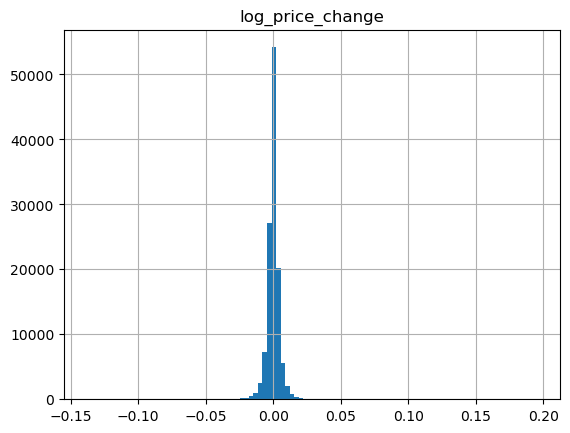

In [8]:
#Plot histogram of log_price_change with 1000 bin and title with plotlib
df["log_price_change"].hist(bins=100).set_title("log_price_change")

Text(0.5, 1.0, 'log_price_change')

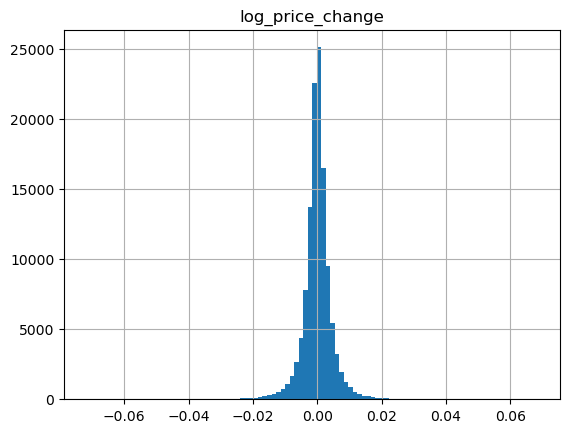

In [9]:
# Plot histogram of log_price_change with 1000 bin and fall under 99% percentile and title with plotlib
df["log_price_change"].hist(bins=100, range=(df["log_price_change"].quantile(0.0001), df["log_price_change"].quantile(0.9999))).set_title("log_price_change")

In [10]:
math.exp(0.02)

1.0202013400267558

In [11]:
raw_data = df[:20]["close"].values

In [12]:
from crypto_feature_preprocess.domains.features_gen import Log_Price_Feature
log_price_feature = Log_Price_Feature(df["close"], 5, 0.02)
log_price_feature_value = log_price_feature.output_feature_array(normalize=True)

Text(0.5, 1.0, 'log_price_feature_value')

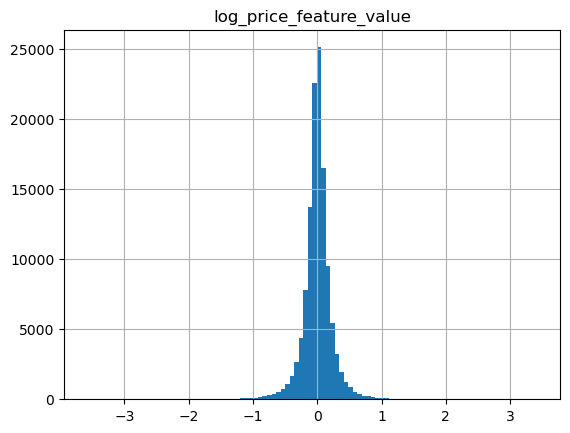

In [13]:
log_price_feature_value[:,0]
#Plot the histogram of log_price_feature_value with 1000 bin and fall under 99% percentile and title with plotlib
pd.Series(log_price_feature_value[:,0]).hist(bins=100, range=(pd.Series(log_price_feature_value[:,0]).quantile(0.0001), pd.Series(log_price_feature_value[:,0]).quantile(0.9999))).set_title("log_price_feature_value")